In [23]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm

df_combined = pd.read_csv('./data/binary_dataset.csv')
#df_combined = pd.read_csv('./data/combined_toxicity_data_cleaned.csv')
#df_combined = df_combined[(df_combined['label'] == '0') | (df_combined['label'] =='1')]

ul = df_combined['label'].unique()
print(ul)

[0 1]


In [24]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())  # 检查 CUDA 是否可用


2.4.0
0.19.0
True


In [34]:
# 划分数据集
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_combined['text_cleaned'].tolist(), df_combined['label'].tolist(), test_size=0.2, random_state=42
)
print(type(train_texts))
# 加载BERT的分词器和模型
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda")
model.to(device)

<class 'list'>


c:\Users\17708\anaconda3\envs\NLP\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# 定义数据集类
class CommentDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
# 创建数据加载器
train_dataset = CommentDataset(train_texts, train_labels)
val_dataset = CommentDataset(val_texts, val_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# 设置优化器
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

In [39]:
print(type(val_dataset))
print(type(val_dataset.encodings))

<class '__main__.CommentDataset'>
<class 'transformers.tokenization_utils_base.BatchEncoding'>


In [40]:
model.eval()
val_labels_list = []
val_preds_list = []
with torch.no_grad():
    batch = next(iter(val_loader))
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    print(type(input_ids))
    print(input_ids)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1)

<class 'torch.Tensor'>
tensor([[  101, 14450,  2015,  ...,     0,     0,     0],
        [  101,  6970,  9148,  ...,     0,     0,     0],
        [  101,  3972, 20624,  ...,     0,     0,     0],
        ...,
        [  101,  2156,  2017,  ...,  2518, 10047,   102],
        [  101,  4668,  2266,  ...,     0,     0,     0],
        [  101,  2356,  4895,  ...,     0,     0,     0]], device='cuda:0')


In [ ]:
# 训练模型
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()
        
        # 将每个张量都明确放到指定设备上
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs} - Training loss: {avg_train_loss}")

    # 验证模型
    model.eval()
    val_labels_list = []
    val_preds_list = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            
            val_labels_list.extend(labels.cpu().numpy())
            val_preds_list.extend(preds.cpu().numpy())
            
    accuracy = accuracy_score(val_labels_list, val_preds_list)
    precision, recall, f1, _ = precision_recall_fscore_support(val_labels_list, val_preds_list, average='binary')
    print(f"Validation Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


Training Epoch 1: 100%|██████████| 8026/8026 [08:48<00:00, 15.17it/s]


Epoch 1/3 - Training loss: 0.1099048264110444
Validation Accuracy: 0.9617, F1: 0.8199, Precision: 0.7981, Recall: 0.8430


Training Epoch 2: 100%|██████████| 8026/8026 [08:47<00:00, 15.22it/s]


Epoch 2/3 - Training loss: 0.07194587180790074
Validation Accuracy: 0.9651, F1: 0.8180, Precision: 0.8870, Recall: 0.7590


Training Epoch 3: 100%|██████████| 8026/8026 [08:45<00:00, 15.27it/s]


Epoch 3/3 - Training loss: 0.04063326019613549
Validation Accuracy: 0.9626, F1: 0.7989, Precision: 0.9009, Recall: 0.7177


Precision: 0.9009, Recall: 0.7177


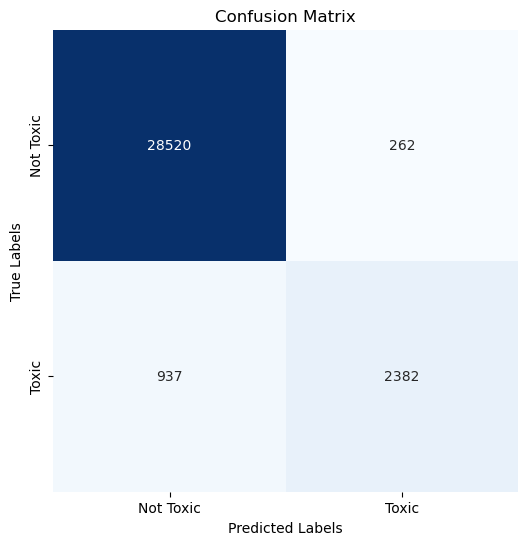

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# 混淆矩阵
conf_matrix = confusion_matrix(val_labels_list, val_preds_list)

# 绘制混淆矩阵
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Not Toxic', 'Toxic'], yticklabels=['Not Toxic', 'Toxic'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# 显示精确率和召回率
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
plt.show()


In [ ]:
model_save_path = "models/bert_model.pt"

# 保存模型权重
torch.save(model.state_dict(), model_save_path)
print(f"模型已保存至 {model_save_path}")

模型已保存至 models/bert_model.pt
